In [1]:
import pandas as pd 
import numpy as np
import pandasql as ps
import os
import re
import joblib
import random 
import numpy as np
import warnings
import tensorflow as tf 
from imblearn.over_sampling import RandomOverSampler
from sklearn.compose import make_column_transformer
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from preprocess_days_stats import preprocess_match_days
from preprocess_time_serie import preprocess_teams, create_time_series_features
from preprocess_time_series_features import preprocess_features_time_series, create_fast_preprocessing_ts, preprocess_features_time_series_odds, create_fast_preprocessing_ts_odds
from helper_functions_tensorflow import CSVLoggerCallback, CSVLoggerCallbackParams
from new_predicts_calc import new_predictions_calc, display_money_win_predict, display_last_previous_odds
from Data_scraping.odds_scraping import refresh_odds

Refreshing the new odds

In [2]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

prima_iterazione = True
today_date = '2023-12-22'
start_filter = 'Empoli - Lazio'
end_filter = 'Roma - Napoli'
home_teams = ['Empoli', 'Sassuolo', 'Monza', 'Salernitana', 'Frosinone', 'Bologna', 'Torino', 'Inter', 'Verona','Roma']
away_teams = ['Lazio', 'Genoa', 'Fiorentina', 'Milan', 'Juventus', 'Atalanta', 'Udinese', 'Lecce','Cagliari','Napoli']
num_matches = len(home_teams)
#refresh_odds(start_filter, end_filter, num_matches, other_matches=False, prima_iterazione=prima_iterazione)

Calculating the new predictions

In [3]:
#set the seed
tf.random.set_seed(42)
np.random.seed(42)
random.seed(12)
last_odds, previous_odds, model_odds_new_compare = new_predictions_calc(today_date, home_teams, away_teams, prima_iterazione)

 numero di squadre: 20, 20 
Reading file: I1 (0).csv
Reading file: I1 (1).csv
Reading file: I1 (10).csv
Reading file: I1 (11).csv
Reading file: I1 (12).csv
Reading file: I1 (13).csv
Reading file: I1 (14).csv
Reading file: I1 (15).csv
Reading file: I1 (16).csv
Reading file: I1 (17).csv
Reading file: I1 (2).csv
Reading file: I1 (3).csv
Reading file: I1 (4).csv
Reading file: I1 (5).csv
Reading file: I1 (6).csv
Reading file: I1 (7).csv
Reading file: I1 (8).csv
Reading file: I1 (9).csv
Reading file: stagione_23_24.csv
preprocessing finished!
utilizzando meno features
preprocess finished
utilizzando meno features
utilizzando meno features
utilizzando meno features
1/1 [==============================] - 0s 304ms/step

 ultima esecuzione : 2023-12-19 18:07:12.413578
489


In [4]:
model_odds_new_compare.head(10)

,hometeam,awayteam,preds,best_pred_prob,money_won,model_away_prob,model_draw_prob,model_home_prob,home_win_odds,draw_odds,away_win_odds,snai_pred,snai_prob,pred_odds,money_won_home,money_won_draw,money_won_away,hometeam1,awayteam1
0,Salernitana,Milan,A,0.663131,0.961540,0.663131,0.241856,0.095013,6.75,4.75,1.45,A,1.45,1.45,0.641341,1.148815,0.961540,Salernitana,Milan
1,Roma,Napoli,A,0.358113,0.913187,0.358113,0.318782,0.323105,2.90,3.10,2.55,A,2.55,2.55,0.937006,0.988224,0.913187,Roma,Napoli
2,Sassuolo,Genoa,H,0.408090,0.897797,0.283561,0.308350,0.408090,2.20,3.35,3.25,H,2.20,2.20,0.897797,1.032971,0.921573,Sassuolo,Genoa
3,Monza,Fiorentina,H,0.356517,1.033898,0.323867,0.319616,0.356517,2.90,3.35,2.40,A,2.40,2.90,1.033898,1.070715,0.777280,Monza,Fiorentina
4,Torino,Udinese,H,0.458268,0.824882,0.240726,0.301006,0.458268,1.80,3.45,4.75,H,1.80,1.80,0.824882,1.038470,1.143450,Torino,Udinese
5,Frosinone,Juventus,A,0.582461,0.949412,0.582461,0.274683,0.142856,5.50,3.85,1.63,A,1.63,1.63,0.785706,1.057530,0.949412,Frosinone,Juventus
6,Empoli,Lazio,A,0.463489,0.926978,0.463489,0.302678,0.233833,3.80,3.35,2.00,A,2.00,2.00,0.888566,1.013971,0.926978,Empoli,Lazio
7,Bologna,Atalanta,A,0.341141,0.921080,0.341141,0.321984,0.336875,2.75,3.10,2.70,A,2.70,2.70,0.926407,0.998150,0.921080,Bologna,Atalanta
8,Inter,Lecce,H,0.746985,0.888912,0.072792,0.180224,0.746985,1.19,6.75,13.00,H,1.19,1.19,0.888912,1.216511,0.946291,Inter,Lecce
9,Verona,Cagliari,H,0.448070,1.052964,0.243429,0.308501,0.448070,2.35,3.25,3.10,H,2.35,2.35,1.052964,1.002628,0.754631,Verona,Cagliari


Displaying the variations of the probability of winning money

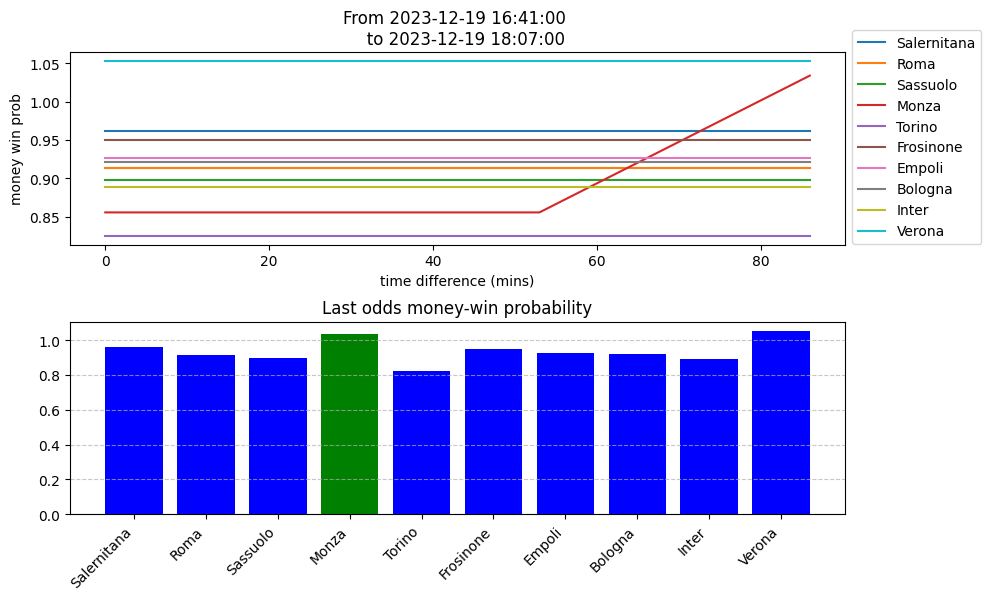

In [5]:
predict_variations = display_money_win_predict()

Displaying the last odds available

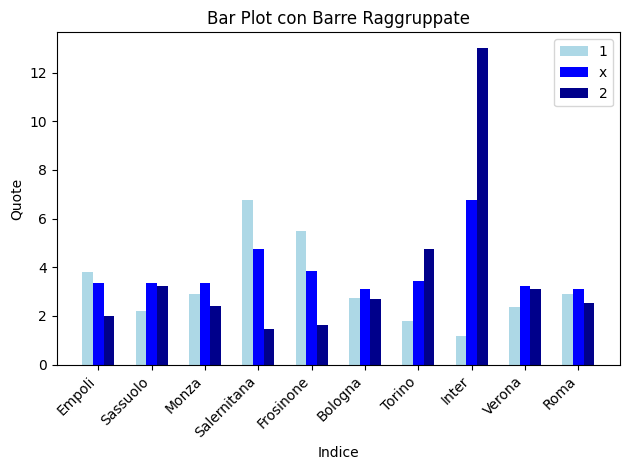

In [6]:
display_last_previous_odds(last_odds, previous_odds, home_teams)

In [7]:
predict_variations.iloc[-5:,:]

,Salernitana,Roma,Sassuolo,Monza,Torino,Frosinone,Empoli,Bologna,Inter,Verona,Date
0,0.96154,0.913187,0.897797,0.855640,0.824882,0.949412,0.926978,0.92108,0.888912,1.052964,2023-12-19 16:41:00
1,0.96154,0.913187,0.897797,0.855640,0.824882,0.949412,0.926978,0.92108,0.888912,1.052964,2023-12-19 17:34:00
2,0.96154,0.913187,0.897797,1.033898,0.824882,0.949412,0.926978,0.92108,0.888912,1.052964,2023-12-19 18:07:00
